In [ ]:
from IPython.display import clear_output
from google.colab import files
files.upload()
#from google.colab import drive
#drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d atulanandjha/lfwpeople
!unzip lfwpeople.zip
!tar -xvzf lfw-funneled.tgz
!rm lfw-funneled.tgz lfwpeople.zip
clear_output()

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow.keras.applications import resnet
from tensorflow.keras.metrics import Mean, CosineSimilarity
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import cv2
from PIL import Image
from glob import glob
from tqdm.notebook import trange, tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    #os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [ ]:
IMAGE_SIZE = 105
BATCH_SIZE = 64
epochs = 5
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def ArcFaceLoss(W, m, s):
    """ Works properly only in custom training loop """
    def inner(y_true, x):
        # replace 0 => 1 and 1=> m in y_true
        M = (m-1) * y_true + 1
        
        # W . x = ||W||*||x||*cos(theta)
        # but ||W|| = 1 and ||x|| = 1
        # so (W . x) = cos(theta) 
        dot_product = tf.linalg.matmul(x, W)
        cos_theta, cos_theta_norms = tf.linalg.normalize(dot_product, axis=0)

        theta = tf.acos(cos_theta)
    
        # add appropriate margin to theta
        new_theta = theta + M
        new_cos_theta = tf.cos(new_theta)
    
        # re-scale the cosines by a hyper-parameter s
        y_pred = s * new_cos_theta     

        # the following part is the same as softmax loss
        numerators = tf.reduce_sum(y_true * tf.exp(y_pred), axis=1)
        denominators = tf.reduce_sum(tf.exp(y_pred), axis=1)
        loss = - tf.reduce_sum(tf.math.log(numerators / denominators))
    
        return loss

    return inner

class ArcFace(Layer):
    def __init__(self, n_classes=10, s=30.0, m=0.50, regularizer=None, **kwargs):
        super(ArcFace, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.regularizer = tf.keras.regularizers.get(regularizer)

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])
        self.W = self.add_weight(name='W',
                                shape=(input_shape[0][-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=self.regularizer)

    def call(self, inputs):
        x, y = inputs
        c = K.shape(x)[-1]
        # normalize feature
        x = tf.nn.l2_normalize(x, axis=1)
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=0)
        # dot product
        logits = x @ W
        # add margin
        # clip logits to prevent zero division when backward
        theta = tf.acos(K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))
        target_logits = tf.cos(theta + self.m)
        # sin = tf.sqrt(1 - logits**2)
        # cos_m = tf.cos(logits)
        # sin_m = tf.sin(logits)
        # target_logits = logits * cos_m - sin * sin_m
        #
        logits = logits * (1 - y) + target_logits * y
        # feature re-scale
        logits *= self.s
        out = tf.nn.softmax(logits)

        return out

    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def crop_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.2, 4)
    if len(faces) > 0:
        for x, y, w, h in faces:
            image2 = image[y: y+h, x: x+w, :]
        image2 = cv2.resize(image2, (IMAGE_SIZE, IMAGE_SIZE))
        return image2, 1
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    return image, 0

In [ ]:
img_dir = glob('lfw_funneled/'+'/*/*')
img_dir = [str(x) for x in img_dir]

df = pd.DataFrame(img_dir, columns=['Image_dir'])
df['Name'] = df['Image_dir'].str.split('/', expand=True).loc[:, [1,]]

In [ ]:
out_names = []
for name in df["Name"].unique():
    if len(df[df["Name"] == name]) < 10:  # 2
        out_names.append(name)
        dirs = df.loc[df.Name==name, "Image_dir"].values.tolist()
        for dr in dirs:
            os.remove(dr)

df = df[~df["Name"].isin(out_names)]
print(len(df))

img_dir = glob('lfw_funneled/'+'/*/*')
img_dir = [str(x) for x in img_dir]

print(len(img_dir))

4324
4324


In [ ]:
folders = list(os.walk("lfw_funneled/"))[1:]

for folder in folders:
    if not folder[2]:
        os.rmdir(folder[0])

In [ ]:
for path in tqdm(df["Image_dir"]):
    image = Image.open(path)
    image = np.array(image)

    image, _ = crop_face(image)
    
    image = Image.fromarray(image)
    image.save(path)

  0%|          | 0/4324 [00:00<?, ?it/s]

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory="lfw_funneled",
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(105, 105),
    shuffle=True,
    seed=42,
    validation_split=0.1,
    subset="training",
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory="lfw_funneled",
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(105, 105),
    shuffle=False,
    seed=42,
    validation_split=0.1,
    subset="validation",
)

Found 4324 files belonging to 158 classes.
Using 3892 files for training.
Found 4324 files belonging to 158 classes.
Using 432 files for validation.


In [ ]:
rescale = lambda x, y: (x/127.5 - 1, y)
train_ds = train_ds.map(rescale, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.map(rescale, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def build_model(num_classes=df["Name"].nunique()):
    input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    label = tf.keras.Input(shape=(num_classes,))

    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten() (x)
    x = tf.keras.layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = ArcFace(num_classes, regularizer=tf.keras.regularizers.l2(1e-4))([x, label])

    model = tf.keras.Model([input, label], output)
    model.build(input_shape=model.inputs)

    return model

model = build_model()

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 103, 103, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 103, 103, 32  128        ['conv2d_3[0][0]']               
 rmalization)                   )                                                           

In [ ]:
model.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

_callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
            ]
callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=True, model=model)

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model([x, y], training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value, logits

# @tf.function
def test_step(x, y):
    val_logits = model([x, y], training=False)
    loss_value = tf.keras.losses.categorical_crossentropy(y, val_logits, from_logits=True)
    loss_value = np.mean(loss_value)
    return loss_value, val_logits

In [ ]:
train_acc, valid_acc = [], []
train_losses, valid_losses = [], []
logs = {}
callbacks.on_train_begin(logs=logs)
wait = 0
best = np.inf

for epoch in range(1, epochs+1):
    print(f"Epoch {epoch} / {epochs+1}")
    callbacks.on_epoch_begin(epoch, logs=logs)

    train_acc_ep, train_loss_ep = [], []
    for step, (x_batch, y_batch) in tqdm(enumerate(train_ds), leave=False):
        callbacks.on_batch_begin(step, logs=logs)
        callbacks.on_train_batch_begin(step, logs=logs)

        loss_value, logits = train_step(x_batch, y_batch)
        accuracy = accuracy_score(y_batch.numpy().argmax(1), logits.numpy().argmax(1))
        
        logs = {"loss": loss_value, "train_accuracy": accuracy}
        callbacks.on_train_batch_end(step, logs=logs)
        callbacks.on_batch_end(step, logs=logs)

        train_acc_ep.append(accuracy)
        train_loss_ep.append(loss_value.numpy())
        break
    print(f"Loss: {np.mean(train_loss_ep):.4f}, accuracy: {np.mean(train_acc_ep):.4f}")

    valid_acc_ep, valid_loss_ep = [], []
    for step, (x_batch, y_batch) in tqdm(enumerate(valid_ds), leave=False):
        callbacks.on_batch_begin(step, logs=logs)
        callbacks.on_test_batch_begin(step, logs=logs)

        loss_value, logits = test_step(x_batch, y_batch)
        accuracy = accuracy_score(y_batch.numpy().argmax(1), logits.numpy().argmax(1))

        logs = {"val_loss": loss_value, "val_accuracy": accuracy}
        callbacks.on_train_batch_end(step, logs=logs)
        callbacks.on_batch_end(step, logs=logs)

        valid_acc_ep.append(accuracy)
        valid_loss_ep.append(loss_value)
    print(f"Loss: {np.mean(valid_loss_ep):.4f}, accuracy: {np.mean(valid_acc_ep):.4f}")

    callbacks.on_epoch_end(epoch, logs=logs)

callbacks.on_train_end(logs=logs)
history_object = None
for callback in callbacks:
    if isinstance(callback, tf.keras.callbacks.History):
        history_object = callback
assert history_object is not None

In [ ]:
# model -> load weights / on the fly
# new_model = Model(inputs=model.input[0], outputs=model.layers[-3].output)

# features = new_model.predict(X_test, verbose=1)
# features /= np.linalg.norm(features, axis=1, keepdims=True)
model.layers[-3]  # arc_layer is not needed, dropout turns off when inference -> output is a 128-vector

In [ ]:
people = np.zeros((len(df), 105, 105, 3))

for i in trange(len(df)):
    image = Image.open(df.iloc[i,0])
    image = np.array(image)
    people[i, ...] = image

  0%|          | 0/4324 [00:00<?, ?it/s]

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(df["Name"])

In [ ]:
labels = tf.keras.utils.to_categorical(labels)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(people, labels, test_size=0.2, random_state=42)

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=10),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ]

In [ ]:
model.fit([x_train, y_train], y_train,
            batch_size=32,
            epochs=100,
            validation_data=([x_test, y_test], y_test),
            callbacks=callbacks,
            verbose=1)

Epoch 1/100
109/109 [==============================] - 3s 20ms/step - loss: 19.9021 - categorical_accuracy: 0.0000e+00 - val_loss: 18.0619 - val_categorical_accuracy: 0.0139 - lr: 0.0010
Epoch 2/100
109/109 [==============================] - 2s 17ms/step - loss: 17.1142 - categorical_accuracy: 0.0116 - val_loss: 16.6876 - val_categorical_accuracy: 0.0474 - lr: 0.0010
Epoch 3/100
109/109 [==============================] - 2s 19ms/step - loss: 14.5621 - categorical_accuracy: 0.0382 - val_loss: 14.0412 - val_categorical_accuracy: 0.1272 - lr: 0.0010
Epoch 4/100
109/109 [==============================] - 2s 17ms/step - loss: 12.7100 - categorical_accuracy: 0.0630 - val_loss: 12.6260 - val_categorical_accuracy: 0.1561 - lr: 0.0010
Epoch 5/100
109/109 [==============================] - 2s 17ms/step - loss: 11.3204 - categorical_accuracy: 0.0781 - val_loss: 11.2782 - val_categorical_accuracy: 0.2116 - lr: 0.0010
Epoch 6/100
109/109 [==============================] - 2s 17ms/step - loss: 10.27

In [ ]:
new_model = tf.keras.Model(inputs=model.input[0], outputs=model.layers[-3].output)

In [ ]:
features = new_model.predict(x_test, verbose=0)
features /= np.linalg.norm(features, axis=1, keepdims=True)
y_test_ = np.argmax(y_test, axis=-1)
cosine_similarity = tf.keras.metrics.CosineSimilarity()

Text(0.5, 0.92, 'ArcFAce')

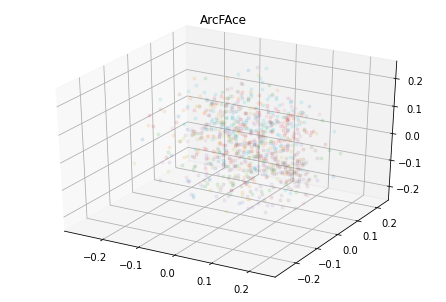

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig1 = plt.figure()
ax1 = Axes3D(fig1)
for c in range(len(np.unique(y_test_))):
    ax1.plot(features[y_test_==c, 0], features[y_test_==c, 1], features[y_test_==c, 2], '.', alpha=0.1)
plt.title('ArcFAce')
# разделение особо и не произошло

In [ ]:
image1 = Image.open(df.loc[4654, "Image_dir"])
image2 = Image.open(df.loc[4666, "Image_dir"])
img1 = np.array(image1)[None]
img2 = np.array(image2)[None]
img1 = img1 / 127.5 - 1
img2 = img2 / 127.5 - 1

out1 = new_model.predict(img1, verbose=0).ravel()
out2 = new_model.predict(img2, verbose=0).ravel()

# out1 /= np.linalg.norm(out1, axis=-1, keepdims=True)
# out2 /= np.linalg.norm(out2, axis=-1, keepdims=True)

similarity = cosine_similarity(out1, out2)
# similarity = out1 @ out2

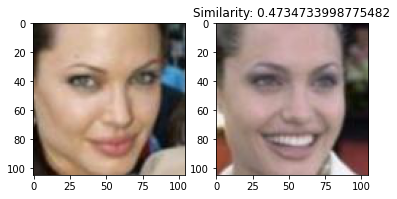

In [ ]:
plt.subplot(121)
plt.imshow(image1)
plt.subplot(122)
plt.imshow(image2)
plt.title(f"Similarity: {similarity}")
plt.show()

In [ ]:
image1 = Image.open(df.loc[11, "Image_dir"])
image2 = Image.open(df.loc[4654, "Image_dir"])
img1 = np.array(image1)[None]
img2 = np.array(image2)[None]
img1 = img1 / 127.5 - 1
img2 = img2 / 127.5 - 1

out1 = new_model.predict(img1, verbose=0).ravel()
out2 = new_model.predict(img2, verbose=0).ravel()

# out1 /= np.linalg.norm(out1, axis=-1, keepdims=True)
# out2 /= np.linalg.norm(out2, axis=-1, keepdims=True)

similarity = cosine_similarity(out1, out2)
# similarity = out1 @ out2

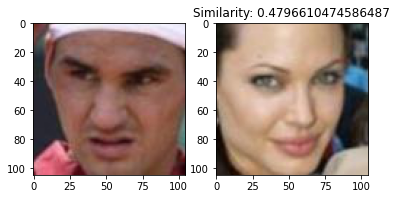

In [ ]:
plt.subplot(121)
plt.imshow(image1)
plt.subplot(122)
plt.imshow(image2)
plt.title(f"Similarity: {similarity}")
plt.show()